In [179]:
import botorch
from known_boundary.acquisition_function import EI,SLogEI,EI_acquisition_opt,MES_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Beale,Branin,Rosenbrock,SixHumpCamel,Hartmann,Powell,DixonPrice,Levy,StyblinskiTang,Griewank
import obj_functions.push_problems
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


function_information = []
fstar=0.397887 
distances = np.array([0.1,1,2,5,10,50,100,1000])

temp={}
temp['name']='Branin2D' 
temp['function'] = Branin(negate=False)
temp['fstar'] =  0.397887 
function_information.append(temp)

# temp={}
# temp['name']='DixonPrice4D' 
# temp['function'] = DixonPrice(dim=4,negate=False)
# temp['fstar'] = 0.
# temp['min']=True 
# function_information.append(temp)

In [181]:
information = function_information[0]

In [193]:
total_record = []
total_record2 = []

for dist in distances:
    
    
    print('!!!!distance is: ',dist)
    
 

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim

    
    # fstar = dist #information['fstar']
    
    # print('fstar is: ',fstar)
    

    step_size = 2
    iter_num = 1
    N = 25

    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,20]
    noise = 1e-6
    
    print(information['name'])
    ratio_holder = []
    ######################## SlogGP+logEI#######################################

    for exp in range(N):

        seed = exp
       
        print(exp)

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
       
       
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)



        best_record = [Y_BO.min().item()]
        np.random.seed(1234)
       
        boundarys = []
        variances = []


    
        i = 0
        print('inner loop: ',i)

        
        train_Y = Y_BO.numpy()
        
        print('so far best: ',np.min(train_Y))
        fstar = np.min(train_Y) - dist
        
        if i%step_size == 0  :
            Y_min = np.min(train_Y)
            Y_std = np.std(train_Y-Y_min)
            
        fstar_shifted = fstar -Y_min # shifted lower bound
        train_Y = train_Y - Y_min  # shift Y
        
        #scalise Y_shift and fstar_shift
        train_Y = train_Y/Y_std
        fstar_shifted = fstar_shifted/Y_std
    

        
        train_X = normalize(X_BO, bounds)
        train_X = train_X.numpy()
        
        lower = -fstar_shifted
        upper = 10**(-6)+lower
        
    
            
        c_range = [lower,upper]

        if i%step_size == 0:
            
            parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                

            lengthscale = parameters[0]
            variance = parameters[1]
            c = parameters[2]
        
        print('lengthscale is ',lengthscale)
        print('variance is ',variance)
        print('lower bound is ',-c*Y_std+Y_min)
        
            
        boundarys.append(-c*Y_std+Y_min)
        variances.append(variance)
        
        
        warp_Y = np.log(train_Y+c)
        mean_warp_Y = np.mean(warp_Y) # use to predict mean
        warp_Y_standard = warp_Y-mean_warp_Y
        
        
        kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
        m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
        m.Gaussian_noise.variance.fix(noise)
        
        np.random.seed(i)
        standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,
                                                f_mean=mean_warp_Y)
        
        
        
        # parameters = opt_model_MLE(train_X,train_Y,dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range) 
        # lengthscale = parameters[0]
        # variance = parameters[1]
    
        # kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
        # m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
        # m.Gaussian_noise.fix(noise)
        
        # acq_val = EI(X=standard_next_X,dim=dim,f_best=np.min(train_Y),model=m,f_star='no')
        # mean,var = m.predict_noiseless(standard_next_X.reshape(-1,dim))
        # f_best = np.min(train_Y)
        # z = (f_best - mean)/np.sqrt(var)        
        # out=(f_best - mean) * norm.cdf(z)
        # ratio = out/acq_val[0]
        # ratio_holder.append(ratio)
        # print('acquisition is ',acq_val[0])
        # print('exploit is ',out)
        # print('ratio is: ',ratio)
        acq_val = SLogEI(X=standard_next_X,dim=dim,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,model=m)
        mean,var = m.predict_noiseless(standard_next_X.reshape(-1,dim))
        mu = mean+mean_warp_Y
        predictMean = np.exp(mu+0.5*var)-c
        print('mean is ',predictMean)
        print('so far best is: ',np.min(train_Y) )
        print('acqusition is: ',acq_val)
        ratio = (np.min(train_Y) - predictMean)/acq_val
        ratio_holder.append(ratio)
        
    total_record2.append(ratio_holder)
   
        


!!!!distance is:  0.1
Branin2D
0
inner loop:  0
so far best:  3.5451968551073154
lengthscale is  0.19253983374773542
variance is  4.667671740845593
lower bound is  3.4451605272247106
mean is  [[0.00089266]]
so far best is:  0.0
acqusition is:  [0.00044498]
1
inner loop:  0
so far best:  9.746850357467707
lengthscale is  0.20706492193446893
variance is  7.459589551120269
lower bound is  9.646850357467688
mean is  [[0.00247584]]
so far best is:  0.0
acqusition is:  [0.00036895]
2
inner loop:  0
so far best:  7.693125871351419
lengthscale is  0.09011526657198611
variance is  5.63460284910946
lower bound is  7.593125864820522
mean is  [[0.00204974]]
so far best is:  0.0
acqusition is:  [0.00022769]
3
inner loop:  0
so far best:  5.0943023750419325
lengthscale is  0.17357630151028622
variance is  5.437366223642159
lower bound is  4.994243026242434
mean is  [[0.00109753]]
so far best is:  0.0
acqusition is:  [0.00025296]
4
inner loop:  0
so far best:  8.843966319397879
lengthscale is  0.0015

In [194]:
dist

1000.0

In [195]:
aa = np.array(total_record2)

In [196]:
aa = aa.reshape(8,25)

In [197]:
np.mean(aa,1)

array([-6.96859660e+04, -3.43583606e+00, -3.11504445e+00, -2.43473630e+00,
       -2.12681862e+00, -1.18508697e+00, -8.60457525e-01, -2.94693595e-01])

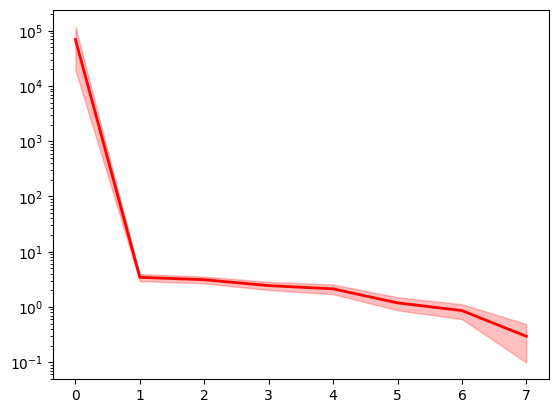

In [201]:
N = aa.shape[1]

std = np.std(aa,axis=1)

mean = -np.mean(aa,axis=1)

iter = np.array(range(aa.shape[0]))

lower = mean - 1*std/np.sqrt(N)
upper = mean + 1*std/np.sqrt(N)

lower.astype(float)
upper.astype(float)


plt.plot(mean,linewidth=2,label='distance',color='red')
plt.fill_between(iter, lower, upper,alpha=0.25,color='red')

plt.yscale("log")    

In [50]:
iter

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [49]:
lower

array([0.62419034, 0.62461942, 0.71604723, 0.7247233 , 0.73845377,
       0.73984039, 0.71922418])

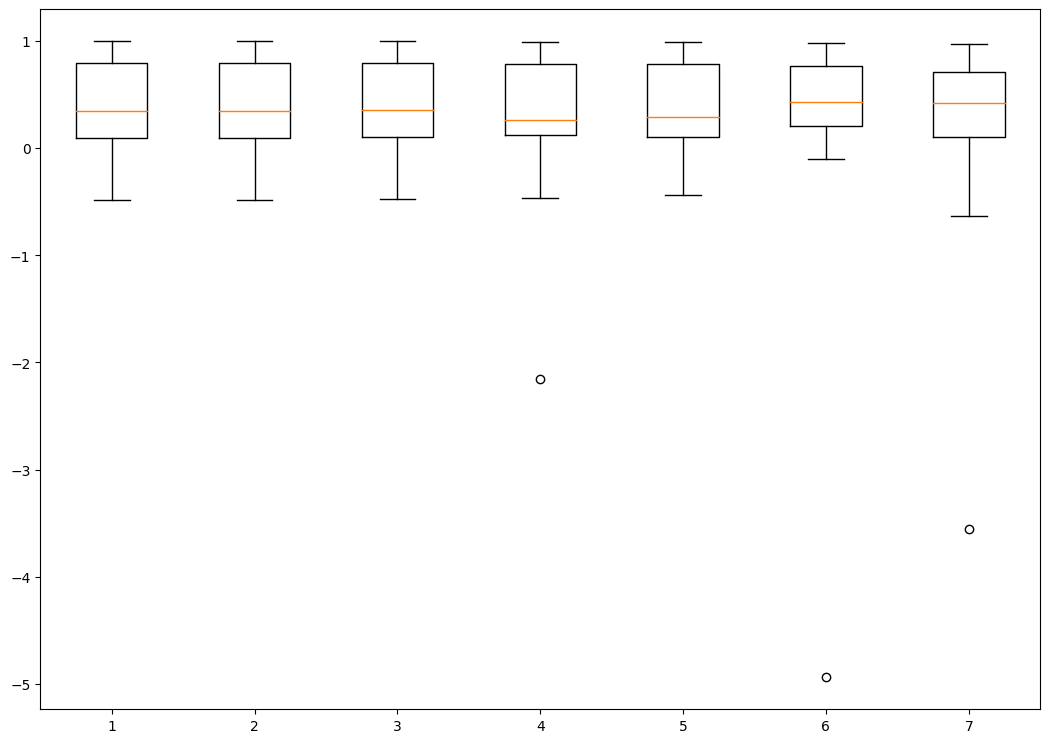

In [166]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
 

 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(aa.T)
 
# show plot
plt.show()

In [32]:
total_record[2]

[0.9119174833663886,
 0.7106530295524167,
 0.84159730640848,
 0.7203835328805136,
 0.9272017411272908,
 0.57305268481865,
 0.7265836954021498]

In [25]:
nextX_distance

[0.7476743630195987,
 0.7735569734271627,
 0.6863512775527374,
 0.5713169138916274,
 1.0262649238512915,
 0.6264984876790668,
 0.8726061212971028]

In [24]:
total_record[0]

[[0.9168461765148856,
  0.7090998633101737,
  0.8518196725889989,
  0.6914060260326897,
  0.40502097419435334,
  0.5158928327073602,
  0.4223728856550133],
 [0.9168461765148856,
  0.7090998633101737,
  0.8518196725889989,
  0.6914060260326897,
  0.40502097419435334,
  0.5158928327073602,
  0.4223728856550133],
 [0.9168461765148856,
  0.7090998633101737,
  0.8518196725889989,
  0.6914060260326897,
  0.40502097419435334,
  0.5158928327073602,
  0.4223728856550133],
 [0.9168461765148856,
  0.7090998633101737,
  0.8518196725889989,
  0.6914060260326897,
  0.40502097419435334,
  0.5158928327073602,
  0.4223728856550133],
 [0.9168461765148856,
  0.7090998633101737,
  0.8518196725889989,
  0.6914060260326897,
  0.40502097419435334,
  0.5158928327073602,
  0.4223728856550133],
 [0.9168461765148856,
  0.7090998633101737,
  0.8518196725889989,
  0.6914060260326897,
  0.40502097419435334,
  0.5158928327073602,
  0.4223728856550133],
 [0.9168461765148856,
  0.7090998633101737,
  0.8518196725889989

In [17]:
total_record[0]

[[0.9168461765148856,
  0.7090998633101737,
  0.8518196725889989,
  0.6914060260326897,
  0.40502097419435334,
  0.5158928327073602,
  0.4223728856550133]]

In [21]:
total_record[5]

IndexError: list index out of range

In [10]:
np.array(LogEI_fixedC).shape

(7, 7)

In [32]:
np.savetxt(information['name']+'_SLogGP+logEI_fixedC_distanceRecord_'+dist, np.array(LogEI_fixedC), delimiter=',')

TypeError: can only concatenate str (not "float") to str

In [30]:
LogEI_fixedC

[0.9175786164514728,
 0.6862830932551158,
 0.8470330473511083,
 0.7002563793871291,
 0.40502097419435334,
 0.5252317764919967,
 0.4223728856550133,
 0.8922129106908129,
 0.6846378265828214,
 0.7666404804237776,
 0.5456300305041962,
 0.6688120043823091]

In [25]:
np.savetxt(information['name']+'_SLogGP+logEI_fixedC_distanceRecord_'+dist, np.array(LogEI_fixedC), delimiter=',')

TypeError: can only concatenate str (not "float") to str

In [24]:
np.array(LogEI_fixedC)

array([[0.91757862],
       [0.68628309],
       [0.84703305],
       [0.70025638],
       [0.40502097],
       [0.52523178],
       [0.42237289],
       [0.89221291],
       [0.68463783],
       [0.76664048],
       [0.54563003],
       [0.668812  ]])

In [22]:
nextX_distance

[0.6688120043823091]

In [18]:
LogEI_fixedC[0][0][0][0]

0.9175786164514728

In [12]:
standard_next_X.shape

(2,)

In [13]:
bestX.shape

(2,)

In [2]:
train_Y

array([[0.92876029],
       [0.        ],
       [3.00692163],
       [1.89181219],
       [0.92021553],
       [0.77369801],
       [2.83665298],
       [0.84552793]])